In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
usecols = [ 'latitude', 'longitude','price',
       'minimum_nights', 'number_of_reviews','reviews_per_month','calculated_host_listings_count',
       'availability_365']
df = pd.read_csv('AB_NYC_2019.csv',usecols=usecols)

In [3]:
df

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,40.64749,-73.97237,149,1,9,0.21,6,365
1,40.75362,-73.98377,225,1,45,0.38,2,355
2,40.80902,-73.94190,150,3,0,NaN,1,365
3,40.68514,-73.95976,89,1,270,4.64,1,194
4,40.79851,-73.94399,80,10,9,0.10,1,0
...,...,...,...,...,...,...,...,...
48890,40.67853,-73.94995,70,2,0,NaN,2,9
48891,40.70184,-73.93317,40,4,0,NaN,2,36
48892,40.81475,-73.94867,115,10,0,NaN,1,27
48893,40.75751,-73.99112,55,1,0,NaN,6,2


In [4]:
df['price'].median()

106.0

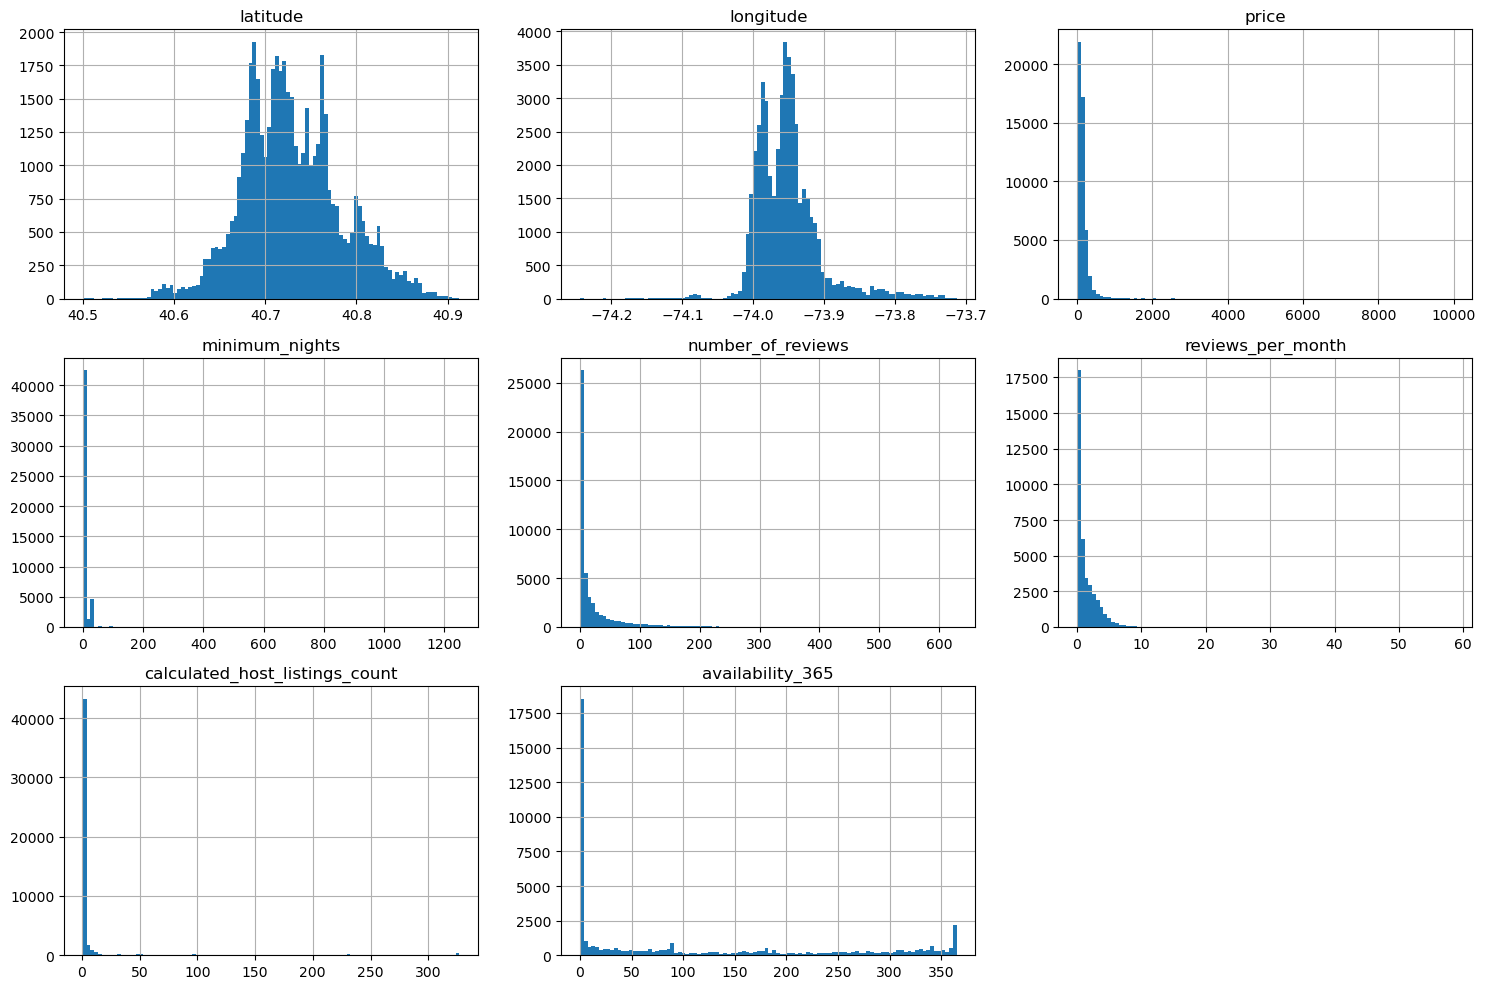

In [5]:
fig = plt.figure(figsize=(15,10))
ax = plt.gca()
df.hist(bins=100, ax=ax, layout=(3,3))

plt.tight_layout()
plt.show()

<AxesSubplot:xlabel='price', ylabel='Density'>

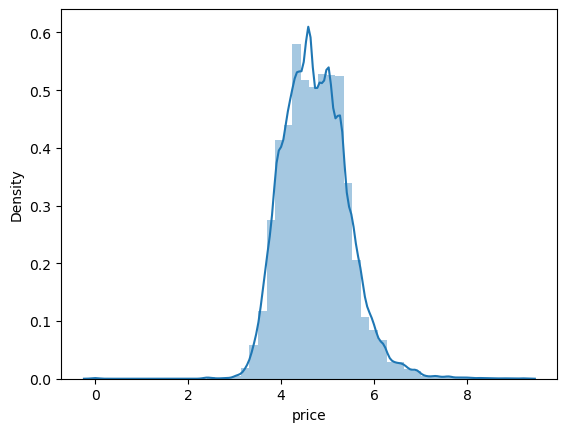

In [6]:
sns.distplot(np.log1p(df.price))

In [7]:
# Split data without using sklearn. 
n = len(df)
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)
## Shuffle it /
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_shuffled = df.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
df_test = df_shuffled.iloc[n_train + n_val:].copy()
#Reset index number each spliting data sets. 
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


In [8]:
## Preparing the labels
y_train_origin = df_train.price.values
y_val_origin = df_val.price.values
y_test_origin = df_test.price.values

y_train = np.log1p(y_train_origin)
y_val = np.log1p(y_val_origin)
y_test = np.log1p(y_test_origin)

# Deletion dataset 
del df_train['price']
del df_val['price']
del df_test['price']

In [9]:
# Let's see what is going on mean vs zero value for null data

In [57]:
df.isnull().sum()

latitude                              0
longitude                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [45]:
base = ['latitude', 'longitude',
       'minimum_nights', 'number_of_reviews','reviews_per_month','calculated_host_listings_count',
       'availability_365']

def train_linear_regression(X,y): ## Simple linear regresssion form
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    return w[0], w[1:]

def prepare_X(df, fillna_value): # Preparing X value which using fillna then assign data values inside of X.
    df_num=df[base]
    df_num = df_num.fillna(fillna_value)
    X = df_num.values
    return X

def rmse(y, y_pred): ## Get rmse score here. 
    error = y_pred - y
    mse = (error**2).mean()
    return np.sqrt(mse)

In [46]:
mean = df_train.availability_365.mean()

X_train = prepare_X(df_train, fillna_value=mean)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=mean)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

0.642750775310769

In [47]:
X_train = prepare_X(df_train, fillna_value=0)
w_0, w = train_linear_regression(X_train, y_train)

X_val = prepare_X(df_val, fillna_value=0)
y_pred = w_0 + X_val.dot(w)

rmse(y_val, y_pred)

0.6437565168746189

In [48]:
# Regularization

In [49]:
def train_linear_regression_reg(X, y, r=0.0):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    reg = r * np.eye(XTX.shape[0])
    XTX = XTX + reg
    
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]


In [50]:
alpha = [0, 0.000001, 0.0001, .001, .01, .1, 1 ,5, 10]

for r in alpha:
    w_0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w_0 + X_val.dot(w)
    rmse_val = rmse(y_val, y_pred)
    print('r: %06s rmse: %0.5f' % (r, rmse_val))

r:      0 rmse: 0.64376
r:  1e-06 rmse: 0.64376
r: 0.0001 rmse: 0.64373
r:  0.001 rmse: 0.64398
r:   0.01 rmse: 0.65469
r:    0.1 rmse: 0.67598
r:      1 rmse: 0.68098
r:      5 rmse: 0.68147
r:     10 rmse: 0.68154


In [51]:
 # Standard deviation of RMSE

In [52]:
rmses = []

for s in [0,1,2,3,4,5,6,7,8,9]:
    n = len(df)
    
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_train_origin = df_train.price.values
  
    y_val_origin = df_val.price.values
    y_test_origin = df_test.price.values

    y_train = np.log1p(y_train_origin)
    y_val = np.log1p(y_val_origin)
    y_test = np.log1p(y_test_origin)

    del df_train['price']
    del df_val['price']
    del df_test['price']
    

    X_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fillna_value=0)
    y_pred = w_0 + X_val.dot(w)

    result = rmse(y_val, y_pred)
    print(s, result)
    
    rmses.append(result)
    

0 0.6549779961414438
1 0.6462523685109162
2 0.6476558177579959
3 0.637514506955726
4 0.6445809084000428
5 0.6305809996755244
6 0.6297851916850383
7 0.6506184267079381
8 0.6489780353528753
9 0.6437565168746189


In [53]:
np.std(rmses)

0.007932965981196267

In [54]:
# RMSE for test

In [55]:
    n = len(df)
    
    n_val = int(0.2 * n)
    n_test = int(0.2 * n)
    n_train = n - (n_val + n_test)

    idx = np.arange(n)
    np.random.seed(9)
    np.random.shuffle(idx)

    df_shuffled = df.iloc[idx]

    df_train = df_shuffled.iloc[:n_train].copy()
    df_val = df_shuffled.iloc[n_train : n_train + n_val].copy()
    df_test = df_shuffled.iloc[n_train + n_val:].copy()

    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_train_origin = df_train.price.values
  
    y_val_origin = df_val.price.values
    y_test_origin = df_test.price.values

    y_train = np.log1p(y_train_origin)
    y_val = np.log1p(y_val_origin)
    y_test = np.log1p(y_test_origin)

    del df_train['price']
    del df_val['price']
    del df_test['price']
    
    X_train = prepare_X(df_train, fillna_value=0)
    w_0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val, fillna_value=0)
    y_pred = w_0 + X_val.dot(w)

    result = rmse(y_val, y_pred)
    print(result)

0.6437565168746189
